In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import datasets

In [2]:
! pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")

Skipping, found downloaded files in "./sentiment140" (use force=True to force download)


In [5]:
df = pd.read_csv("/content/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin-1',header = None)

In [6]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.shape

(1600000, 6)

In [8]:
### Updating the name of columns

df.columns = ['emotion', 'id', 'date', 'query', 'user_id', 'text']

In [9]:
df.head(2)

,emotion,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [10]:
df.isnull().sum()

emotion    0
id         0
date       0
query      0
user_id    0
text       0
dtype: int64

In [11]:
df["emotion"].value_counts()

0    800000
4    800000
Name: emotion, dtype: int64

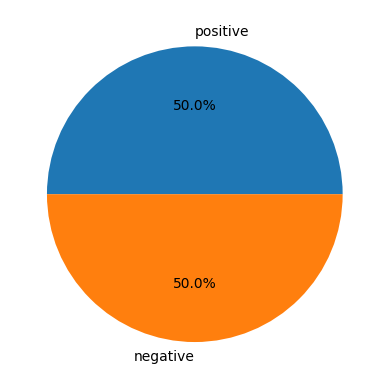

In [12]:
plt.pie(df["emotion"].value_counts(), labels=["positive","negative"], autopct='%1.1f%%')
plt.show()

In [13]:
### Dropping the irrelevant columns from the dataset

df.drop(["id","date","user_id","query"],axis = 1,inplace = True)

In [14]:
df["text"][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

**DATA PREPROCESSING**

In [15]:
### Removing the special characters from the text columns

import re
special_char = r"[^a-zA-Z0-9\s]"
df["text"] = df["text"].str.replace(special_char, "")

In [16]:
df.head()

,emotion,text
0,0,switchfoot httptwitpiccom2y1zl Awww thats a b...
1,0,is upset that he cant update his Facebook by t...
2,0,Kenichan I dived many times for the ball Manag...
3,0,my whole body feels itchy and like its on fire
4,0,nationwideclass no its not behaving at all im ...


<Axes: >

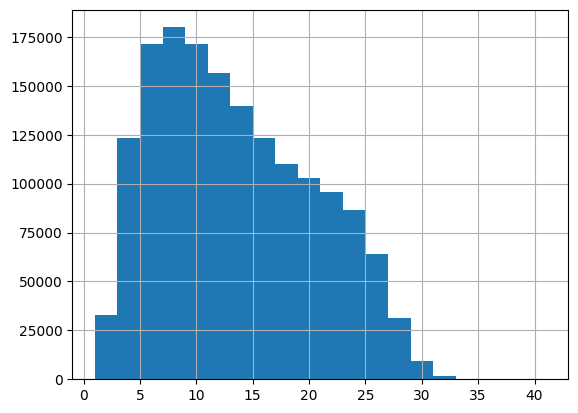

In [17]:
### Checking the data distribution

seq_len = [len(i.split()) for i in df["text"]]
pd.Series(seq_len).hist(bins = 20)

Max length: 180
Min length: 3
Mean length: 70.0179475


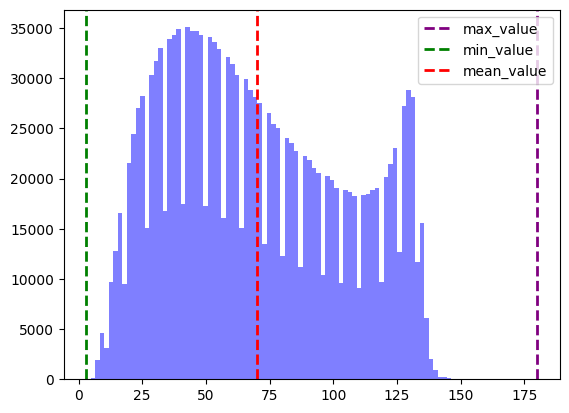

In [18]:
### Checking the text column data details using graphical interpretation

text_len = df["text"].str.len()
max_len = text_len.max()
min_len = text_len.min()
mean_len = text_len.mean()

print("Max length:", max_len)
print("Min length:", min_len)
print("Mean length:", mean_len)

# Plot a histogram of the text lengths
plt.hist(text_len, bins=100, alpha=0.5, color="blue")
plt.axvline(x=max_len, color="purple", linewidth=2, linestyle="dashed", label="max_value")
plt.axvline(x=min_len, color="green", linewidth=2, linestyle="dashed", label="min_value")
plt.axvline(x=mean_len, color="red", linewidth=2, linestyle="dashed", label="mean_value")
plt.legend()
plt.show()

In [19]:
### Importing Required Libraries

!pip install transformers

In [20]:
df['text'] = df['text'].astype('string')
df['text'] = df['text'].astype('category')

texts = df['text'].values
emotions = df['emotion'].values


In [21]:
# Converting emotions to binary labels (0 for negative, 1 for positive)

binary_labels = np.array([1 if emotion == 'positive' else 0 for emotion in emotions])

In [22]:
### Importing Bert

from transformers import DistilBertTokenizerFast, TFDistilBertModel


In [23]:
text_col = df['text'].tolist()
labels = df['emotion'].tolist()

In [24]:
### Spliting the dataset

from sklearn.model_selection import train_test_split
train_texts, test_texts, binary_train_labels, binary_test_labels = train_test_split(
    texts, binary_labels, test_size=0.3, random_state=42
)



In [25]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [26]:
### Tokenizing the train dataset using batch approach as dataset is quite large

train_input_ids = []
train_attention_mask = []
batch_size = 32

for i in range(0, len(train_texts), batch_size):
    batch_texts = train_texts[i:i + batch_size].tolist()
    batch_encodings = tokenizer.batch_encode_plus(batch_texts, truncation=True, padding="max_length", max_length=180)
    train_input_ids.extend(batch_encodings['input_ids'])
    train_attention_mask.extend(batch_encodings['attention_mask'])


train_input_ids = np.array(train_input_ids)
train_attention_mask = np.array(train_attention_mask)




In [27]:
### Tokenizing the test dataset using batch approach as dataset is quite large

test_input_ids = []
test_attention_mask = []

for i in range(0, len(test_texts), batch_size):
    batch_texts = test_texts[i:i + batch_size].tolist()
    batch_encodings = tokenizer.batch_encode_plus(batch_texts, truncation=True, padding="max_length", max_length=180)
    test_input_ids.extend(batch_encodings['input_ids'])
    test_attention_mask.extend(batch_encodings['attention_mask'])

test_input_ids = np.array(test_input_ids)
test_attention_mask = np.array(test_attention_mask)

In [28]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [29]:
### Creating a model, Importing the required libraries

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [30]:
### Converting labels into binary format

binary_train_labels = tf.convert_to_tensor(binary_train_labels, dtype=tf.int64)
binary_test_labels = tf.convert_to_tensor(binary_test_labels, dtype=tf.int64)

In [34]:
### Building the model artichitect
from tensorflow.keras.layers import GlobalMaxPooling1D , Reshape

distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

input_ids = Input(shape=(180,), dtype='int32')
attention_mask = Input(shape=(180,), dtype='int32')

embedding = distilbert_model(input_ids, attention_mask=attention_mask)[0]

pooled_output = tf.reduce_max(embedding, axis=1)

reshaped_output = Reshape((-1, 1))(pooled_output)

output = Dense(units=1, activation='sigmoid')(reshaped_output)

model = Model(inputs=[input_ids, attention_mask], outputs=output)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [35]:
### Muting bert model as not traning the entire model as its already pre trained

for layer in distilbert_model.layers:
    layer.trainable = False

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 180)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_7[0][0]',                
 assification_4 (TFDistilBertFo  rOutput(loss=None,               'input_8[0][0]']                
 rSequenceClassification)       logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [38]:
train_input_ids = tf.convert_to_tensor(train_input_ids, dtype=tf.int32)
train_attention_mask = tf.convert_to_tensor(train_attention_mask, dtype=tf.int32)
test_input_ids = tf.convert_to_tensor(test_input_ids, dtype=tf.int32)
test_attention_mask = tf.convert_to_tensor(test_attention_mask, dtype=tf.int32)

In [47]:
print("train_input_ids",train_input_ids.shape)
print("train_attention_mask",train_attention_mask.shape)
print("binary_train_labels",binary_train_labels.shape)
print("test_input_ids",test_input_ids.shape)
print("binary_test_labels",binary_test_labels.shape)

train_input_ids (1120000, 180)
train_attention_mask (1120000, 180)
binary_train_labels (1120000,)
test_input_ids (480000, 180)
binary_test_labels (480000,)


In [48]:
binary_train_labels = np.expand_dims(binary_train_labels, axis=-1)
binary_test_labels = np.expand_dims(binary_test_labels, axis=-1)


In [50]:
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(
    [train_input_ids, train_attention_mask],
    binary_train_labels,
    epochs=5,
    batch_size=32,
    validation_data=([test_input_ids, test_attention_mask], binary_test_labels)
)

In [ ]:
test_loss, test_accuracy = model.evaluate([test_input_ids, test_attention_mask], binary_test_emotions)
